# YOLO-FACE-MODELL

## Vorbereitung

### Bibliotheken und Module laden

In [1]:
# --------------------------------------------
# 1. nstallation der benötigten Pakete
# --------------------------------------------
!pip install -q kagglehub            # Kaggle-Daten herunterladen/verwalten
!pip install -q pillow matplotlib numpy pandas  # Bildbearbeitung, Visualisierung und Datenanalyse
!pip install -q transformers         # Hugging Face Transformers für ML/Objekterkennung

# --------------------------------------------
# 2. Import der Bibliotheken
# --------------------------------------------
import kagglehub
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import psutil, os, time
import torch
from transformers import AutoImageProcessor, AutoModelForObjectDetection

# --------------------------------------------
# 3. GPU-Überprüfung und Anzeige der Ressourcen
# --------------------------------------------
if torch.cuda.is_available():
    # Wenn eine GPU vorhanden ist, werden Name und Speicherinformationen ausgegeben
    print("GPU verfügbar:", torch.cuda.get_device_name(0))
    print("Totaler GPU-RAM:", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2), "GB")
    print("Verfügbarer GPU-RAM:", round(torch.cuda.memory_reserved(0) / 1e9, 2), "GB")
    print("Nicht belegter GPU-RAM:", round(torch.cuda.memory_allocated(0) / 1e9, 2), "GB")
else:
    # Wenn keine GPU gefunden wird, wird dies ausgegeben
    print("Keine GPU gefunden.")

GPU verfügbar: NVIDIA A16
Totaler GPU-RAM: 15.61 GB
Verfügbarer GPU-RAM: 0.0 GB
Nicht belegter GPU-RAM: 0.0 GB


### Herunterladen und Ausgeben der Daten

Dataset path: /home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3

Erste Ebene im Dataset:
['frames', 'labels.npy', 'labels.csv', 'images.npy']

Erste 5 Zeilen der Labels:
   id  count
0   1     35
1   2     41
2   3     41
3   4     44
4   5     41

Shape der images.npy: (2000, 480, 640, 3)
Shape der labels.npy: (2000, 1)


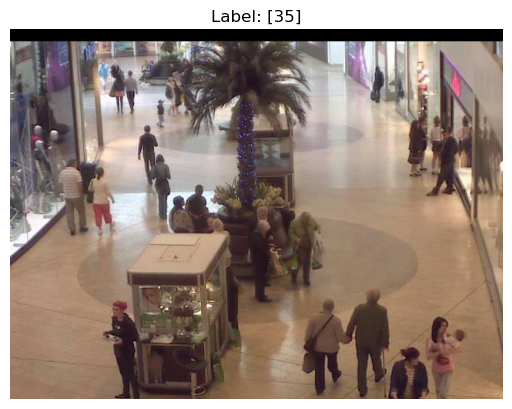


Gefundene Bilddateien im frames-Ordner: 2000
Beispiele: ['/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000895.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000891.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000860.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000862.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000937.jpg']


In [2]:
# --------------------------------------------
# 1. Dataset von Kaggle herunterladen
# --------------------------------------------
base_path = kagglehub.dataset_download("fmena14/crowd-counting")  # Dataset lokal herunterladen
print("Dataset path:", base_path)

# --------------------------------------------
# 2. Inhalt des Dataset-Ordners anzeigen
# --------------------------------------------
print("\nErste Ebene im Dataset:")
print(os.listdir(base_path))  # Zeigt die Hauptdateien und Ordner des Datasets

# --------------------------------------------
# 3. CSV-Datei mit Labels laden
# --------------------------------------------
csv_path = os.path.join(base_path, "labels.csv")
df_labels = pd.read_csv(csv_path)  # Labels als DataFrame einlesen
print("\nErste 5 Zeilen der Labels:")
print(df_labels.head())

# --------------------------------------------
# 4. Numpy-Dateien mit Bildern und Labels laden
# --------------------------------------------
images_path = os.path.join(base_path, "images.npy")
labels_path = os.path.join(base_path, "labels.npy")

images = np.load(images_path)  # Bilder als Numpy-Array laden
labels = np.load(labels_path)  # Labels als Numpy-Array laden

print("\nShape der images.npy:", images.shape)
print("Shape der labels.npy:", labels.shape)

# --------------------------------------------
# 5. Ein Beispielbild anzeigen
# --------------------------------------------
plt.imshow(images[0])  # Erstes Bild anzeigen
plt.title(f"Label: {labels[0]}")  # Passendes Label als Titel
plt.axis("off") # Keine Achsenbeschriftungen
plt.show()

# --------------------------------------------
# 6. Alle Bilder aus dem 'frames'-Ordner laden (rekursiv)
# --------------------------------------------
frames_path = os.path.join(base_path, "frames") # Dateienpfad suchen

# Alle Bilddateien (JPG/PNG) im Ordner und Unterordnern sammeln
image_files = []
for root, dirs, files in os.walk(frames_path):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_files.append(os.path.join(root, f))

print(f"\nGefundene Bilddateien im frames-Ordner: {len(image_files)}")
print("Beispiele:", image_files[:5])


In [3]:
# df_labels: DataFrame mit Spalte "count" (Anzahl Personen)
label_df = df_labels.copy()
label_df.rename(columns={"count": "people"}, inplace=True)

people = label_df["people"].values

In [4]:
def to_ordinal(y):
    """
    Ordinale Targets:
    >10, >20, >30
    """
    return np.stack([
        y > 10,
        y > 20,
        y > 30,
        y > 40
    ], axis=1).astype("float32")

y_ordinal = to_ordinal(people)

In [5]:
# --------------------------------------------
# 7. DataFrame für Labels vorbereiten
# --------------------------------------------
# df_labels enthält Informationen über die Anzahl der Personen pro Bild
label_df = df_labels.copy()  # Kopie erstellen, um das Original nicht zu verändern
label_df.rename(columns={"count": "people"}, inplace=True)  # Spalte "count" in "people" umbenennen

people = label_df["people"].values  # Array mit Personenanzahlen

# --------------------------------------------
# 8. Funktion zur Klassenzuordnung definieren
# --------------------------------------------
# Hier wird die Anzahl der Personen in Klassen eingeteilt:
# 0: <=10 Personen, 1: 11-20, 2: 21-30, 3: 31-40, 4: >40
def assign_class(y):
    if y <= 10:
        return 0
    elif y <= 20:
        return 1
    elif y <= 30:
        return 2
    elif y <= 40:
        return 3
    else:
        return 4

# --------------------------------------------
# 9. lasse jedem Bild hinzufügen
# --------------------------------------------
label_df["people_class"] = [assign_class(x) for x in people]  # Neue Spalte mit Klassen erstellen

# --------------------------------------------
# 10. Kontrolle der ersten Zeilen
# --------------------------------------------
print(label_df.head())  # Zeigt die ersten 5 Zeilen mit Personenanzahl und zugehöriger Klasse

   id  people  people_class
0   1      35             3
1   2      41             4
2   3      41             4
3   4      44             4
4   5      41             4


## Modell Importieren und erstellen


Gefundene Bilddateien im frames-Ordner: 2000
Beispiele: ['/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000895.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000891.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000860.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000862.jpg', '/home/jovyan/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3/frames/frames/seq_000937.jpg']


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


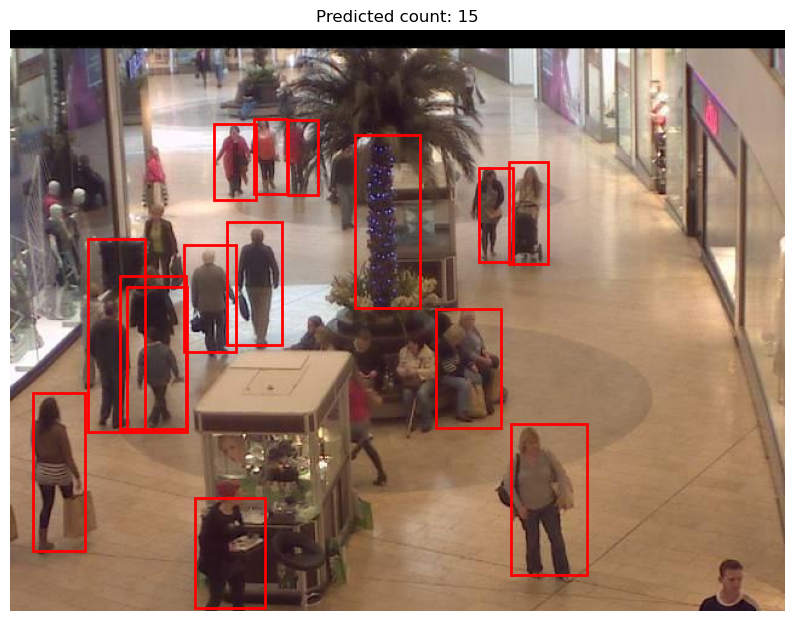

In [6]:
# --------------------------------------------
# 1. Überblick über die Bilddateien im 'frames'-Ordner
# --------------------------------------------
print(f"\nGefundene Bilddateien im frames-Ordner: {len(image_files)}")  # Gesamtanzahl der gefundenen Bilder
print("Beispiele:", image_files[:5])  # Zeigt einige der Bildpfade als Beispiel

# --------------------------------------------
# 2. YOLOS-Modell für Objekterkennung laden
# --------------------------------------------
# YOLOS ist ein Transformer-basiertes Modell für Objekterkennung.
# Hier verwenden wir ein vortrainiertes Modell speziell für die Erkennung von Personen.
processor = AutoImageProcessor.from_pretrained("AdamCodd/yolos-small-person")  # Bildvorverarbeitung laden
model = AutoModelForObjectDetection.from_pretrained("AdamCodd/yolos-small-person")  # Modell laden

model.eval()  # Modell in den Evaluierungsmodus setzen (kein Training)
device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU nutzen, falls verfügbar
model.to(device)  # Modell auf das ausgewählte Gerät verschieben

# --------------------------------------------
# 3. Menschen in den Bildern zählen
# --------------------------------------------
counts_pred = []  # Liste für vorhergesagte Personenanzahlen

for i, img_path in enumerate(image_files):
    # Bild öffnen und in RGB konvertieren (YOLOS benötigt 3-Kanal Bilder)
    img_pil = Image.open(img_path).convert("RGB")
    
    # Bild für das Modell vorbereiten
    # -> Processor skaliert Bild, wandelt es in Tensor um und verschiebt es ggf. auf das Device
    inputs = processor(images=img_pil, return_tensors="pt").to(device)
    
    # Vorhersage durchführen (ohne Gradientenberechnung)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Bounding Boxes extrahieren
    # target_sizes: Modell erwartet die Originalgröße des Bildes (H, W)
    target_sizes = torch.tensor([img_pil.size[::-1]])  # PIL-Bilder haben Größe (W, H), deshalb umdrehen
    results = processor.post_process_object_detection(
        outputs, threshold=0.7, target_sizes=target_sizes
    )[0]  # Erste (und einzige) Batch-Ausgabe nehmen
    
    # Anzahl Personen zählen (Anzahl der erkannten Boxen)
    num_people = len(results["boxes"])
    counts_pred.append(num_people)  # Vorhersage speichern
    
    # Optional: Erstes Bild mit Bounding Boxes visualisieren
    if i == 0:
        import matplotlib.patches as patches
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.imshow(img_pil)  # Originalbild anzeigen
        
        # Jede erkannte Box einzeichnen
        for box in results["boxes"]:
            box = [round(b, 2) for b in box.tolist()]  # Box-Koordinaten runden
            rect = patches.Rectangle(
                (box[0], box[1]),          # linke obere Ecke
                box[2]-box[0],             # Breite
                box[3]-box[1],             # Höhe
                linewidth=2,
                edgecolor='r',             # rote Umrandung
                facecolor='none'           # transparentes Inneres
            )
            ax.add_patch(rect)
        
        plt.title(f"Predicted count: {num_people}")  # Anzahl Personen als Titel
        plt.axis("off")  # Achsen ausblenden
        plt.show()

### Ergebnisse in die Klassen einteilen

In [7]:
# --------------------------------------------
# 1. Ergebnisse in einem DataFrame zusammenführen
# --------------------------------------------
# Wir erstellen einen neuen DataFrame, der die Bildpfade und die vorhergesagte Anzahl Personen enthält.
df_results = pd.DataFrame({
    "image_file": image_files,  # Pfad zu jedem Bild
    "pred_count": counts_pred   # Vorhergesagte Anzahl Personen pro Bild
})

# --------------------------------------------
# 2. Funktion zur Klassenzuordnung
# --------------------------------------------
# Wie zuvor beim Label-DataFrame ordnen wir die absolute Personenanzahl in Klassen ein:
# 0: <=10 Personen, 1: 11-20, 2: 21-30, 3: 31-40, 4: >40
def assign_class(y):
    if y <= 10:
        return 0
    elif y <= 20:
        return 1
    elif y <= 30:
        return 2
    elif y <= 40:
        return 3
    else:
        return 4

# --------------------------------------------
# 4. Klassenzuordnung für die Vorhersagen
# --------------------------------------------
# Wir erstellen eine neue Spalte 'pred_class' im DataFrame
# Jede vorhergesagte Personenanzahl wird in die entsprechende Klasse umgewandelt
df_results["pred_class"] = [assign_class(x) for x in df_results["pred_count"]]

# --------------------------------------------
# 5. Kontrolle der Ergebnisse
# --------------------------------------------
print(df_results.head())  # Zeigt die ersten 5 Zeilen mit Bildpfad, vorhergesagter Personenanzahl und Klasse

                                          image_file  pred_count  pred_class
0  /home/jovyan/.cache/kagglehub/datasets/fmena14...          15           1
1  /home/jovyan/.cache/kagglehub/datasets/fmena14...          10           0
2  /home/jovyan/.cache/kagglehub/datasets/fmena14...           9           0
3  /home/jovyan/.cache/kagglehub/datasets/fmena14...          13           1
4  /home/jovyan/.cache/kagglehub/datasets/fmena14...          16           1


## Evaluation der Ergebnisse

Accuracy der Klassenvorhersagen: 7.80%


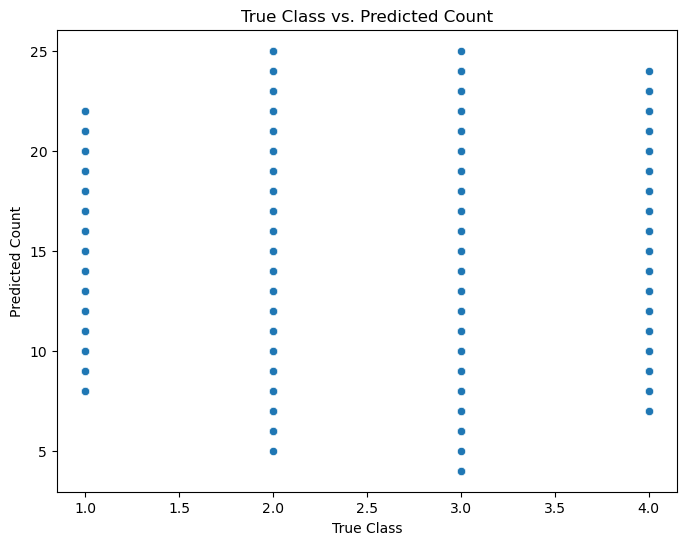

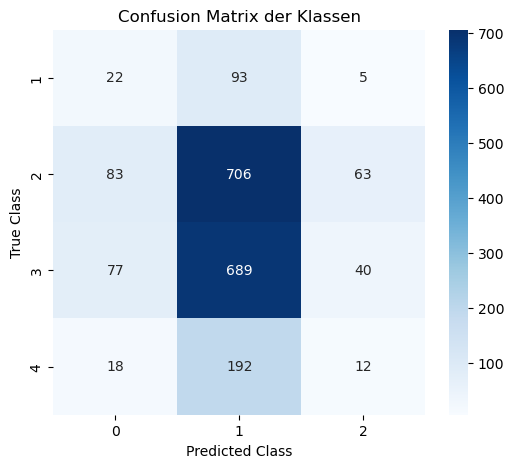

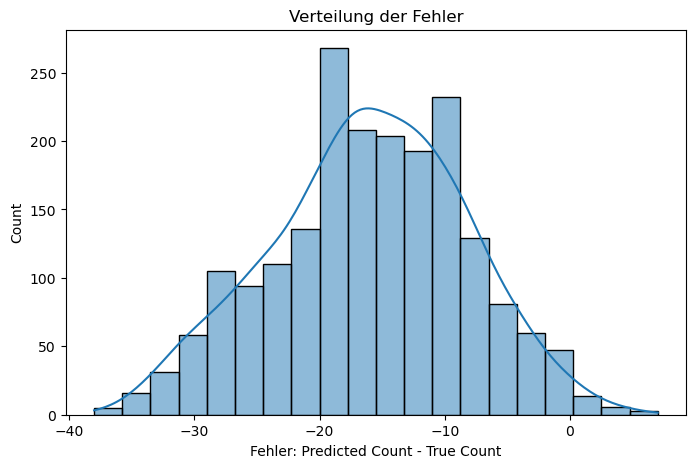

                                          image_file  pred_count  pred_class  \
0  /home/jovyan/.cache/kagglehub/datasets/fmena14...          15           1   
1  /home/jovyan/.cache/kagglehub/datasets/fmena14...          10           0   
2  /home/jovyan/.cache/kagglehub/datasets/fmena14...           9           0   
3  /home/jovyan/.cache/kagglehub/datasets/fmena14...          13           1   
4  /home/jovyan/.cache/kagglehub/datasets/fmena14...          16           1   

   id  true_count  true_class  error_count  abs_error_count  class_match  
0   1          35           3          -20               20        False  
1   2          41           4          -31               31        False  
2   3          41           4          -32               32        False  
3   4          44           4          -31               31        False  
4   5          41           4          -25               25        False  


In [8]:
# ============================================
# 1. Sicherstellen, dass beide DataFrames eine ID-Spalte haben
# ============================================
# df_results (Predictions) bekommt eine fortlaufende ID-Spalte
df_results = df_results.reset_index(drop=True)  # Index zurücksetzen
df_results["id"] = df_results.index + 1        # ID = 1, 2, 3, ...

# label_df (echte Labels) Index zurücksetzen, falls nötig
label_df = label_df.reset_index(drop=True)
# Hinweis: label_df["id"] existiert bereits laut vorheriger Anzeige, daher keine Aktion nötig

# Predicted Klasse erneut sicherstellen (falls vorher geändert)
df_results["pred_class"] = [assign_class(x) for x in df_results["pred_count"]]

# ============================================
# 2. Merge: Vorhersagen mit echten Labels zusammenführen
# ============================================
# Merge über die ID-Spalte, um Vorhersagen und echte Werte in einem DataFrame zu haben
df_results = df_results.merge(
    label_df[["id", "people", "people_class"]],  # Nur relevante Spalten aus den Labels
    on="id",                                     # Merge anhand der ID
    how="left"                                   # Left-Join: alle Vorhersagen behalten
)

# Spalten umbenennen für bessere Lesbarkeit
df_results.rename(columns={
    "people_class": "true_class",  # Echte Klasse
    "people": "true_count"         # Echte Anzahl Personen
}, inplace=True)

# ============================================
# 3. Fehlerberechnung und Accuracy
# ============================================
# Unterschied zwischen vorhergesagter und echter Anzahl Personen
df_results["error_count"] = df_results["pred_count"] - df_results["true_count"]

# Absoluter Fehler
df_results["abs_error_count"] = df_results["error_count"].abs()

# Übereinstimmung der Klassen prüfen (True = richtig, False = falsch)
df_results["class_match"] = df_results["pred_class"] == df_results["true_class"]

# Accuracy der Klassenvorhersagen berechnen
accuracy = df_results["class_match"].mean()
print(f"Accuracy der Klassenvorhersagen: {accuracy*100:.2f}%")

# ============================================
# 4. Visualisierung der Ergebnisse
# ============================================

# a) Scatterplot: True Class vs. Predicted Count
plt.figure(figsize=(8,6))
sns.scatterplot(x="true_class", y="pred_count", data=df_results)
plt.xlabel("True Class")                # Echte Klasse
plt.ylabel("Predicted Count")           # Vorhergesagte Anzahl Personen
plt.title("True Class vs. Predicted Count")
plt.show()

# b) Confusion Matrix: True Class vs. Pred Class
# Zeigt, wie oft jede Klasse korrekt/inkorrekt vorhergesagt wurde
conf_matrix = pd.crosstab(df_results["true_class"], df_results["pred_class"])
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix der Klassen")
plt.show()

# c) Histogramm der Fehler (Predicted Count - True Count)
plt.figure(figsize=(8,5))
sns.histplot(df_results["error_count"], bins=20, kde=True)
plt.xlabel("Fehler: Predicted Count - True Count")
plt.title("Verteilung der Fehler")
plt.show()

# ============================================
# 5. Ergebnisse prüfen
# ============================================
# Zeigt die ersten 5 Zeilen mit Bild, Vorhersage, Klasse und Fehler
print(df_results.head())